# Assignment 2
## ISPR 23/24, third assignment
### by Andrea Marino (matr. 561935)

### Preliminary stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
#from PIL import Image              # Python Image Library

from typing import List, Tuple

In [2]:
if(colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_PATH = "drive/MyDrive/ISPR/Compitini ISPR/Terzo Compitino/"
    sys.path.insert(0,BASE_PATH)
    #os.chdir(BASE_PATH)
    #!pip install -U torch           # update PyTorch
    #!pip install -U torchvision     # update torchvision
else:
    BASE_PATH = ""


In [3]:
import torch
from torch import nn

Let's also set PyTorch's seed to a fixed value, for reproducibility but also to get the same splits in the datasets we're going to create

In [4]:
torch.manual_seed(42)

Finally, we define the device.

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Data, Dataset and Dataloaders

Since I already used the dataset for the first assignment, I don't need to download it again. I just have to fetch it from the right directory (in a way that deals with both Colab and my local install)

In [6]:
HORSE_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/horse/")
MASK_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/mask/")

HORSE_PATH, MASK_PATH

('../Primo Compitino/weizmann_horse_db/horse/',
 '../Primo Compitino/weizmann_horse_db/mask/')

We now need to create the class for the dataset, as required by PyTorch.

We can also apply transformations on our data. The principal transformation worth talking about has to deal with the batch size and the shape of the images. 

If in our `DataLoader`s the batch size is set to be greater than 1, then the images have to be of the same shape (height * width), otherwise the associated tensors can't be stacked in a single batch tensor. This is unfortunate, we can deal with it in three ways:
1. Always online learning algorithm (aka batch_size=1)
2. Resize the image
3. Add a padding of zeros to the smaller images, to bring them all to the same size as the bigger image in the dataset (and then let the model deal with the extra padding).

All three options are interesting for their own reasons, so writing a more general code that allows one to apply each of the ideas is worthwhile.

The first option allows to assess the model's performance on images of different sizes, an interesting challenge for sure. The second option is the most promising and most powerful one, as torchvision's tools seems to do a good job at resizing both the images and the mask, upon preliminary checking. The third option is pretty rough, but it might be interesting to see how the model performs in this case.

In [7]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import Lambda

class HorseDataset(Dataset):
    def __init__(self, 
                 image_path=HORSE_PATH,
                 mask_path=MASK_PATH,
                 transform=Lambda(lambda img: img/255), # normalize pixel values
                 target_transform=None):
        self.img_dir = image_path
        self.mask_dir = mask_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # We know that the answer is 327 but let's make it
        # more general and structured
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path, mask_path = self._horsePath(idx+1)
        img = read_image(img_path)      
        mask = read_image(mask_path)   
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        return img, mask
    
    def __iter__(self):
        for i in range(len(self)):
            yield self.__getitem__(i)    
    
    def _horsePath(self, h:int):
        '''
        Returns the path to the horse image
        whose number (in the filename) is h
        '''
        number = "0"*(2-int(np.log10(h)))+str(h)
        imgname = "horse" + number + ".png"
        img_path = self.img_dir + imgname
        mask_path = self.mask_dir + imgname
        return img_path, mask_path

To apply the transformations as described, we need the height and width of the biggest and smallest images in the dataset.

In [8]:
plain_dataset = HorseDataset()

MAX, MIN = (0,0), (np.inf,np.inf)
biggest, smallest = -1,-1

for i, (img, _) in enumerate(plain_dataset,start=1):
    img_h, img_w = tuple(img.shape[1:])
    if img_h*img_w > MAX[0]*MAX[1]:
        MAX = (img_h, img_w)
        biggest = i
    if img_h*img_w < MIN[0]*MIN[1]:
        MIN = (img_h, img_w)
        smallest = i

print(f"The biggest image is horse {biggest}, of size {MAX[0]}x{MAX[1]}")
print(f"The smallest image is horse {smallest}, of size {MIN[0]}x{MIN[1]}")

The biggest image is horse 65, of size 960x1280
The smallest image is horse 16, of size 148x231


In [9]:
image0, mask0 = plain_dataset[0]
print(f"Image shape: {image0.shape}, mask shape: {mask0.shape}")
print(f"Image type: {image0.dtype}, mask type: {mask0.dtype}")
print(f"Image values range: {torch.min(image0).item()} - {torch.max(image0).item()}")
print(f"Mask values range: {torch.min(mask0).item()} - {torch.max(mask0).item()}")

Image shape: torch.Size([3, 590, 800]), mask shape: torch.Size([1, 590, 800])
Image type: torch.float32, mask type: torch.uint8
Image values range: 0.0 - 1.0
Mask values range: 0 - 1


#### Horse dataset of unchanged images

We create a dataset following the first option.

We can use the `random_split` to create the training set and the test set. 

20% of the whole dataset is held out as test set. I chose this approach over cross-validation to alleviate the computational burden.

In [10]:
from torch.utils.data import random_split

# Create the developement and test datasets
train_size = int(0.8 * len(plain_dataset))
test_size = len(plain_dataset) - train_size

training_plain_dataset, test_plain_dataset = random_split(plain_dataset, [train_size, test_size])

Now we can create the DataLoaders for the training and test data, using batch size of 1 since we applied no transformation

In [11]:
from torch.utils.data import DataLoader

# Attenzione:
BATCH_SIZE = 1

train_plain_dataloader = DataLoader(training_plain_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_plain_dataloader = DataLoader(test_plain_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Horse dataset of resized images

Let's see how the `HorseDataset` class allows us to create a dataset of resized images.

In [12]:
from torchvision.transforms import Resize

#resize_transform = lambda h,w: Lambda(lambda X: Resize((h,w))(X))
def resize_transform(height:int, width:int):
    return Lambda(lambda X: Resize((height,width))(X))

In [13]:
# We can resize to the smallest, or choose any other size
h, w = 256, 256

dataset_resized = HorseDataset(transform=resize_transform(h,w), 
                              target_transform=resize_transform(h,w))

for img, mask in dataset_resized:
    assert img.shape == (3,h,w) and mask.shape == (1,h,w)

print("All images and masks have been resized correctly")

All images and masks have been resized correctly


DataLoader creation:


In [14]:
training_resized_dataset, test_resized_dataset = random_split(dataset_resized, [train_size, test_size])

BATCH_SIZE = 4

train_resized_dataloader = DataLoader(training_resized_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_resized_dataloader = DataLoader(test_resized_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
print(f"Training: n° images is {len(train_plain_dataloader.dataset)}, n° of minibatches is: {len(test_plain_dataloader)}")
print(f"Test: n° images is {len(test_plain_dataloader.dataset)}, n° of minibatches is: {len(test_plain_dataloader)}")

for X, y in train_plain_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: [N, C, H, W]", y.shape, y.dtype)
    break

Training: n° images is 261, n° of minibatches is: 66
Test: n° images is 66, n° of minibatches is: 66
Shape of X [N, C, H, W]:  torch.Size([1, 3, 580, 504])
Shape of y: [N, C, H, W] torch.Size([1, 1, 580, 504]) torch.uint8


#### Horse dataset of padded images

Lastly, we create a dataset of padded images using the `HorseDataset` class.

Instead of passing a fixed amount of padding to the transformation, we pass it the target height and width of the image.

In [16]:
from torchvision.transforms import Pad

#pad_transform = lambda target_h, target_w: Lambda(lambda X: Pad((X.shape[1]-target_h, X.shape[2]-target_w), fill=0)(X))
def pad_transform(target_h:int, target_w:int):
    return Lambda(lambda X: Pad((X.shape[1]-target_h, X.shape[2]-target_w), fill=0)(X))

In [17]:
h, w = MAX

dataset_padded = HorseDataset(transform=pad_transform(h,w), 
                              target_transform=pad_transform(h,w))

# Check that things are ok

DataLoader creation:

In [18]:
training_padded_dataset, test_padded_dataset = random_split(dataset_padded, [train_size, test_size])

BATCH_SIZE = 4

train_padded_dataloader = DataLoader(training_padded_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_padded_dataloader = DataLoader(test_padded_dataset, batch_size=BATCH_SIZE, shuffle=True)

---

### Intermezzo: resizing

In [19]:
img0, mask0 = training_plain_dataset[0]
img0.shape, mask0.shape

(torch.Size([3, 289, 245]), torch.Size([1, 289, 245]))

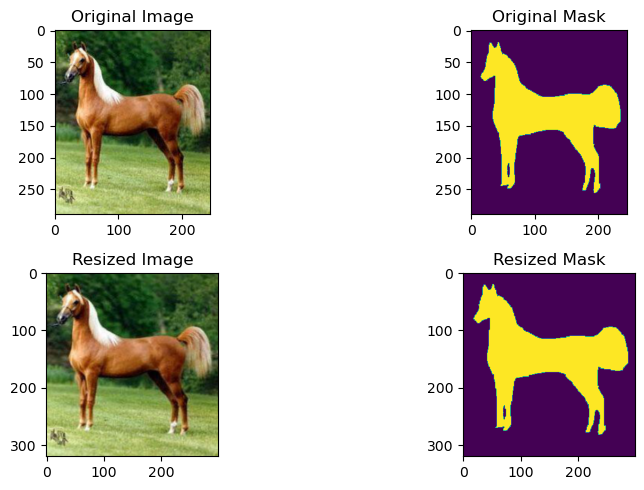

In [20]:
h, w = 320, 300

rsz_img0, rsz_mask0 = Resize((h,w))(img0), Resize((h,w))(mask0)

fig, ax = plt.subplots(2,2, figsize=(10,5))
ax = ax.ravel()
ax[0].imshow(img0.permute(1,2,0))
ax[0].set_title("Original Image")
ax[1].imshow(mask0.permute(1,2,0))
ax[1].set_title("Original Mask")
ax[2].imshow(rsz_img0.permute(1,2,0))
ax[2].set_title("Resized Image")
ax[3].imshow(rsz_mask0.permute(1,2,0))
ax[3].set_title("Resized Mask")

plt.tight_layout()
plt.show()

### The model

The task is semantic segmentation of the horse from the background. The chosen model for this task is a *U-shaped network* that uses convolution and transposed convolutions. Given the context, such a network could be referred as a horseshoe network.

Our horseshoe network has two parts: an encoder and a decoder. For the sake of simplicity (and cleanness of code), these are split into two parts.

Let's start with the `HorseshoeEncoder`. Even though that's somewhat ambiguous and deplorable (the ambiguity is also in the literature), inside a convolutional layer three things will happen:
- A given number of convolutional filters will be applied
- The (batch of) resulting feature maps will be normalized
- An activation function is applied

The `conv_layer` nested function returns a convolutional layer as a `Sequential` container. 

We can specify the structure of our decoder via the `architecture` parameter of the constructor. This parameter is a list of tuple, each tuple being relative to a *block*. A block in this context is just a sequence of convolutional filters followed by a max pooling. More precisely, each tuple in the list specifies how many convolutional layers we want to stack before applying the pooling (1st component of the tuple), and how many convolutional filters there are in each layer inside the block.

In abstract terms, our encoder is just a sequence of blocks. In practice, each block is again a Sequential module, and the encoder's layers are implemented as a `nn.ModuleDict`. A dictionary of modules is used because we need to keep track of the pooling indices of the maximum element. 

In [24]:
class HorseshoeEncoder(nn.Module):
    def __init__(self,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],) -> None:
        super(HorseshoeEncoder, self).__init__()

        def conv_layer(in_channels, out_channels, *args, **kwargs):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        self.layers = nn.ModuleDict()
        self.pooling_indices = []
        self.input_sizes = []

        in_channels = 3  # initial number of input channels
        for i, (n_blocks, out_channels) in enumerate(architecture):
            conv_layers = []
            for _ in range(n_blocks):
                conv_layers.append(conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=0))
                in_channels = out_channels
            
            # We add a MaxPooling layer after the prescribed number of conv layers
            conv_layers.append(nn.MaxPool2d(2,2,return_indices=True))    # Max pooling
            self.layers.add_module(f'conv_block_{i}',nn.Sequential(*conv_layers))

        # I may have to redo the math here... Is 256 ok? Too much? What happens?
        self.conv1x1 = nn.Conv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        #pooling_indices = []
        for block in self.layers.values():
            # we need to keep track also of the input sizes
            self.input_sizes.append(x.size())
            # applying block also applies the pooling
            x, indices = block(x)
            # We need to keep track of the indices for the unpooling
            self.pooling_indices.append(indices)
        x = self.conv1x1(x)
        return x#, self.pooling_indices



In [42]:
class HorseshoeDecoder(nn.Module):
    def __init__(self,
                 architecture:List[Tuple]=[(3,128),(3,128),(3,64),(2,32),(2,16)],) -> None:
        super(HorseshoeDecoder, self).__init__()

        def transp_conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=0):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        self.decoder = nn.ModuleDict()
        #self.unpooling_indices = []

        in_channels = 256

        # I have to add the corresponding 1x1 deconvolution
        # and check that dimensions match

        for i, (n_blocks, out_channels) in enumerate(architecture[::-1]):
            transp_conv_layers = []
            for _ in range(n_blocks):
                transp_conv_layers.append(transp_conv_layer(in_channels, out_channels))
                in_channels = out_channels
            transp_conv_layers.append(nn.MaxUnpool2d(2,2)) 
            self.decoder.add_module(f'transp_conv_block_{i}',nn.Sequential(*transp_conv_layers))  

    def forward(self, x, pooling_indices, input_sizes):
        for block, indices, size in zip(self.decoder.values(), pooling_indices[::-1], input_sizes[::-1]):
            x = block(x, indices)
        return x

Da cambiare sotto:

In [21]:
class HorseshoeNetwork(nn.Module):

    # Very much wip
    def __init__(self,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],):
        super(HorseshoeNetwork, self).__init__()

        # -------------- Convolutional layers --------------
        self.encoder = HorseshoeEncoder(architecture)

        # -------------- Transpose conv. layers --------------
        self.decoder = HorseshoeDecoder(architecture[::-1])
        
    def forward(self, x):
        # DON'T LOOK!!
        for layer in self.encoder.values():
            x = layer(x)
        x = self.conv1x1(x)
        x = torch.sigmoid(x)
        return x

#### Prove strane e a caso. Esperimenti puntuali

In [ ]:
model = HorseshoeNetwork()
print(model)

HorseshoeNetwork(
  (encoder): ModuleDict(
    (conv_block_0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block_1): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [37]:
myEncoder = HorseshoeEncoder()
#print(myEncoder)

In [38]:
img, mask = next(iter(train_plain_dataloader))

X, idxs = myEncoder(img)
print(f"Shapes: X: {X.shape}, idxs: {len(idxs)}")
print(f"types: {type(X)}, {type(idxs)}")

Shapes: X: torch.Size([1, 256, 13, 19]), idxs: 5
types: <class 'torch.Tensor'>, <class 'list'>


In [40]:
X.shape, len(idxs), idxs[-1].shape

(torch.Size([1, 256, 13, 19]), 5, torch.Size([1, 128, 13, 19]))

In [44]:
myDecoder = HorseshoeDecoder()
print(myDecoder)

HorseshoeDecoder(
  (decoder): ModuleDict(
    (transp_conv_block_0): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(256, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    )
    (transp_conv_block_1): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, a